# Function to Generate CSV Files

In [264]:
import csv
import os

def generate_csv_files(stock_symbols):
    """
    Generate calls, puts, and RSI CSV files for the given list of stock symbols.

    Args:
    - stock_symbols (list): A list of stock symbols.

    Returns:
    - dict: A dictionary containing the stock symbols as keys and their respective CSV file names as values.
    """
    csv_files = {}

    for symbol in stock_symbols:
        # Generate file names
        calls_file = f"{symbol}_aggregated_calls.csv"
        puts_file = f"{symbol}_aggregated_puts.csv"
        rsi_file = f"{symbol}_rsi.csv"

        # Write empty CSV files
        with open(calls_file, mode='w', newline='') as calls_csv:
            csv_writer = csv.writer(calls_csv)
            csv_writer.writerow([])  # Write empty row

        with open(puts_file, mode='w', newline='') as puts_csv:
            csv_writer = csv.writer(puts_csv)
            csv_writer.writerow([])  # Write empty row

        with open(rsi_file, mode='w', newline='') as rsi_csv:
            csv_writer = csv.writer(rsi_csv)
            csv_writer.writerow([])  # Write empty row

        # Add file names to the dictionary
        csv_files[symbol] = {
            'calls': calls_file,
            'puts': puts_file,
            'rsi': rsi_file
        }

    return csv_files

In [265]:
import csv

def rsi_csv_to_dict(file_name):
    """
    Convert data from a CSV file to a dictionary.

    Args:
    - file_name (str): The name of the CSV file.

    Returns:
    - dict: A dictionary containing data from the CSV file.
    """
    data_dict = {}

    # Open the CSV file and read the data
    with open(file_name, mode='r') as file:
        # Create a CSV reader object
        csv_reader = csv.DictReader(file, delimiter='\t')
        
        # Iterate over each row in the CSV file
        for row in csv_reader:
            rsi_data = row[',rsi']
            timestamp, rsi_value = rsi_data.split(',')
            data_dict[timestamp] = [rsi_value]

    return data_dict


In [266]:
import csv

def csv_to_dict(file_name):
    """
    Convert data from a CSV file to a dictionary.

    Args:
    - file_name (str): The name of the CSV file.

    Returns:
    - dict: A dictionary containing data from the CSV file.
    """
    data_dict = {}

    # Open the CSV file and read the data
    with open(file_name, mode='r') as file:
        # Create a CSV reader object
        csv_reader = csv.DictReader(file, delimiter='\t')
        
        # Iterate over each row in the CSV file
        for row in csv_reader:
            value = row[',change,num_trades,volume']
            timestamp, change, num_trades, volume = [float(attr) if attr.replace('.', '', 1).isdigit() else attr for attr in value.split(',')]
            data_dict[timestamp] = [change, num_trades, volume]

    return data_dict


# Function to Test RSI Strategy on Calls and Plot

In [267]:
def calculate_precision_and_accuracy(rsi_dict, calls_dict, puts_dict, input_rsi):
    true_positives, false_positives = 0, 0
    total, next_calls, length = 0, 0, len(rsi_dict)
    average_change, average_neg_change = 0, 0
    for timestamp, rsi in rsi_dict.items():
        rsi_value = rsi[0]
        timestamp_dt = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        next_timestamp_dt = timestamp_dt + datetime.timedelta(minutes=5)
        next_timestamp_str = next_timestamp_dt.strftime('%Y-%m-%d %H:%M:%S')
        if float(rsi_value) >= input_rsi: 
            total += 1
        if timestamp in calls_dict and float(rsi_value) >= input_rsi:
            true_positives += 1
            value = calls_dict[timestamp]
            average_change += value[0]
            if next_timestamp_str in calls_dict: 
                next_calls += 1
        if timestamp in puts_dict and float(rsi_value) >= input_rsi:
            false_positives += 1
            value = puts_dict[timestamp]
            average_neg_change += float(value[0])
            

    # Calculate precision, accuracy, and average change
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    accuracy = true_positives / total if total > 0 else  0
    average_change /= true_positives if true_positives > 0 else 1  
    average_neg_change /= false_positives if false_positives > 0 else 1
    
    # Print the metrics including the average change
    print("Input RSI:", input_rsi, "| True Positives:", true_positives, "| False Positives:", false_positives, "| Total:", total, "| Length:", length, "| Total Ratio:", total/length, "| Next Calls Ratio:", next_calls, "| Average Change:", average_change, "| Average Neg Change:", average_neg_change)
    
    # Return precision, accuracy, and ratio
    return precision, accuracy, total/length, next_calls/true_positives


In [270]:
import matplotlib.pyplot as plt

def plot_metrics_vs_rsi(rsi_dict, calls_dict, puts_dict, ticker):
    """
    Plot precision, accuracy, ratio, and next_calls_ratio vs. RSI values.

    Args:
    - rsi_dict (dict): Dictionary containing RSI values.
    - calls_dict (dict): Dictionary containing call data.
    - puts_dict (dict): Dictionary containing put data.
    - ticker (str): Ticker symbol of the stock.
    """
    # Define the range of RSI values to try
    rsi_values = list(range(20, 81, 5))

    # Initialize lists to store precision, accuracy, ratio, and next_calls_ratio values
    precision_values = []
    accuracy_values = []
    ratio_values = []
    next_calls_ratio_values = []

    # Iterate over each RSI value
    for input_rsi in rsi_values:
        # Calculate precision, accuracy, ratio, and next_calls_ratio for the current RSI value
        precision, accuracy, ratio, next_calls_ratio = calculate_precision_and_accuracy(rsi_dict, calls_dict, puts_dict, input_rsi)
        
        # Append precision, accuracy, ratio, and next_calls_ratio values to the lists
        precision_values.append(precision)
        accuracy_values.append(accuracy)
        ratio_values.append(ratio)
        next_calls_ratio_values.append(next_calls_ratio)

    # Plot precision, accuracy, ratio, and next_calls_ratio values
    plt.figure(figsize=(12, 6))

    # Plot precision
    plt.plot(rsi_values, precision_values, label='Precision', marker='o')

    # Plot accuracy
    plt.plot(rsi_values, accuracy_values, label='Accuracy', marker='o')

    # Plot ratio
    plt.plot(rsi_values, ratio_values, label='Ratio', marker='o')

    # Plot next_calls_ratio
    plt.plot(rsi_values, next_calls_ratio_values, label='Next Calls Ratio', marker='o')

    plt.title(f'Precision, Accuracy, Ratio, and Next Calls Ratio vs. RSI Values for {ticker}')
    plt.xlabel('RSI Values')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.show()

AMZN_aggregated_calls.csv AMZN_aggregated_puts.csv AMZN_rsi.csv
Input RSI: 20 | True Positives: 512 | False Positives: 482 | Total: 1901 | Length: 1981 | Total Ratio: 0.9596163553760727 | Next Calls Ratio: 116 | Average Change: 0.5499722656249996 | Average Neg Change: -0.5105168049792531
Input RSI: 25 | True Positives: 502 | False Positives: 449 | Total: 1838 | Length: 1981 | Total Ratio: 0.92781423523473 | Next Calls Ratio: 113 | Average Change: 0.552839243027888 | Average Neg Change: -0.507450334075724
Input RSI: 30 | True Positives: 478 | False Positives: 405 | Total: 1716 | Length: 1981 | Total Ratio: 0.8662291771832408 | Next Calls Ratio: 107 | Average Change: 0.5563211297071126 | Average Neg Change: -0.502460493827161
Input RSI: 35 | True Positives: 460 | False Positives: 352 | Total: 1577 | Length: 1981 | Total Ratio: 0.7960625946491671 | Next Calls Ratio: 104 | Average Change: 0.5593543478260865 | Average Neg Change: -0.5026105113636364
Input RSI: 40 | True Positives: 420 | Fal

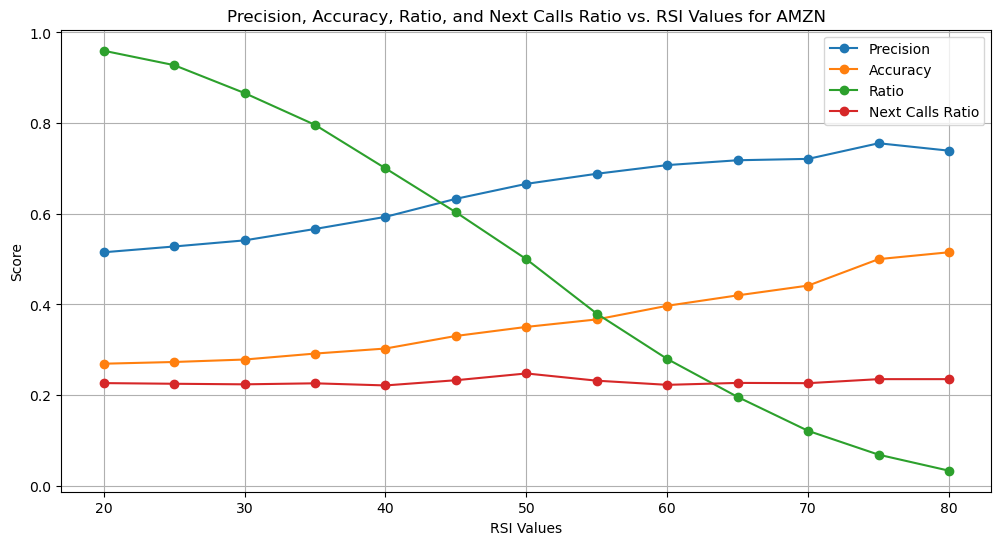

MSFT_aggregated_calls.csv MSFT_aggregated_puts.csv MSFT_rsi.csv
Input RSI: 20 | True Positives: 461 | False Positives: 473 | Total: 1929 | Length: 1981 | Total Ratio: 0.9737506309944473 | Next Calls Ratio: 90 | Average Change: 1.0244052060737534 | Average Neg Change: -1.0358211416490484
Input RSI: 25 | True Positives: 456 | False Positives: 443 | Total: 1870 | Length: 1981 | Total Ratio: 0.9439676930843008 | Next Calls Ratio: 90 | Average Change: 1.028262719298246 | Average Neg Change: -1.0307015801354402
Input RSI: 30 | True Positives: 444 | False Positives: 404 | Total: 1767 | Length: 1981 | Total Ratio: 0.8919737506309945 | Next Calls Ratio: 90 | Average Change: 1.0324860360360366 | Average Neg Change: -1.037281188118811
Input RSI: 35 | True Positives: 416 | False Positives: 352 | Total: 1620 | Length: 1981 | Total Ratio: 0.817768803634528 | Next Calls Ratio: 84 | Average Change: 1.0387322115384618 | Average Neg Change: -1.019530113636363
Input RSI: 40 | True Positives: 388 | False 

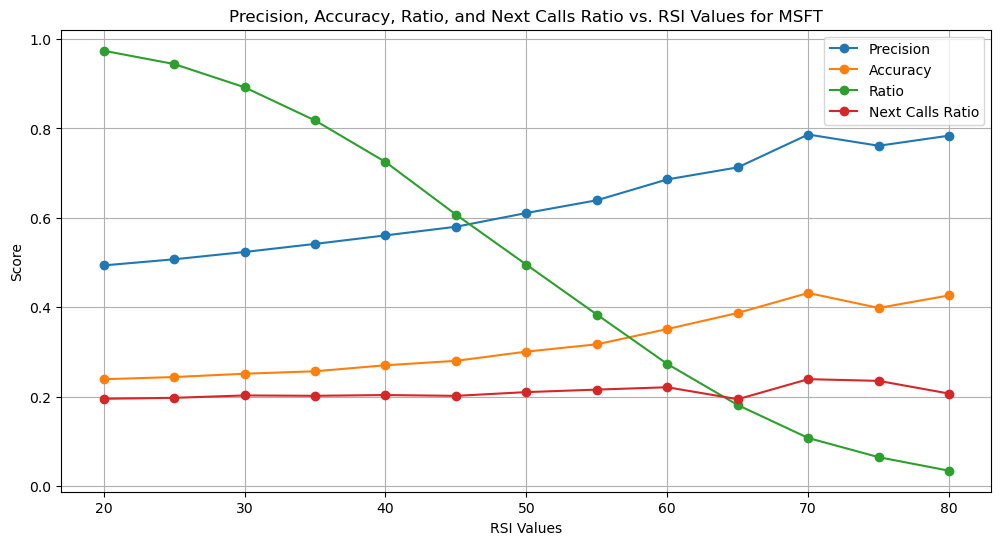

TSLA_aggregated_calls.csv TSLA_aggregated_puts.csv TSLA_rsi.csv
Input RSI: 20 | True Positives: 511 | False Positives: 486 | Total: 1882 | Length: 1981 | Total Ratio: 0.95002523977789 | Next Calls Ratio: 107 | Average Change: 1.4870673189823862 | Average Neg Change: -1.4147059670781899
Input RSI: 25 | True Positives: 499 | False Positives: 445 | Total: 1795 | Length: 1981 | Total Ratio: 0.906108026249369 | Next Calls Ratio: 104 | Average Change: 1.4811468937875738 | Average Neg Change: -1.415893033707866
Input RSI: 30 | True Positives: 481 | False Positives: 409 | Total: 1695 | Length: 1981 | Total Ratio: 0.8556284704694599 | Next Calls Ratio: 100 | Average Change: 1.4911143451143434 | Average Neg Change: -1.400909779951101
Input RSI: 35 | True Positives: 463 | False Positives: 352 | Total: 1557 | Length: 1981 | Total Ratio: 0.7859666834931852 | Next Calls Ratio: 96 | Average Change: 1.4951261339092858 | Average Neg Change: -1.3792693181818187
Input RSI: 40 | True Positives: 421 | Fals

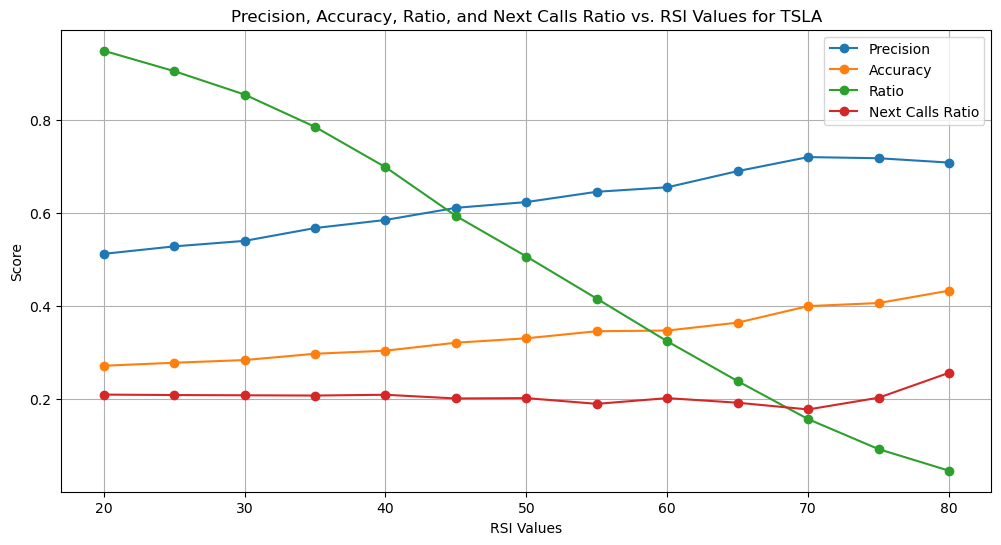

GOOG_aggregated_calls.csv GOOG_aggregated_puts.csv GOOG_rsi.csv
Input RSI: 20 | True Positives: 544 | False Positives: 465 | Total: 1933 | Length: 1981 | Total Ratio: 0.9757698132256436 | Next Calls Ratio: 130 | Average Change: 0.48383290441176535 | Average Neg Change: -0.44649182795698966
Input RSI: 25 | True Positives: 539 | False Positives: 443 | Total: 1886 | Length: 1981 | Total Ratio: 0.9520444220090863 | Next Calls Ratio: 129 | Average Change: 0.48078961038961093 | Average Neg Change: -0.4406717832957113
Input RSI: 30 | True Positives: 533 | False Positives: 412 | Total: 1813 | Length: 1981 | Total Ratio: 0.9151943462897526 | Next Calls Ratio: 127 | Average Change: 0.4811549718574115 | Average Neg Change: -0.43436674757281557
Input RSI: 35 | True Positives: 506 | False Positives: 372 | Total: 1693 | Length: 1981 | Total Ratio: 0.8546188793538617 | Next Calls Ratio: 121 | Average Change: 0.48601501976284633 | Average Neg Change: -0.4312465053763442
Input RSI: 40 | True Positives:

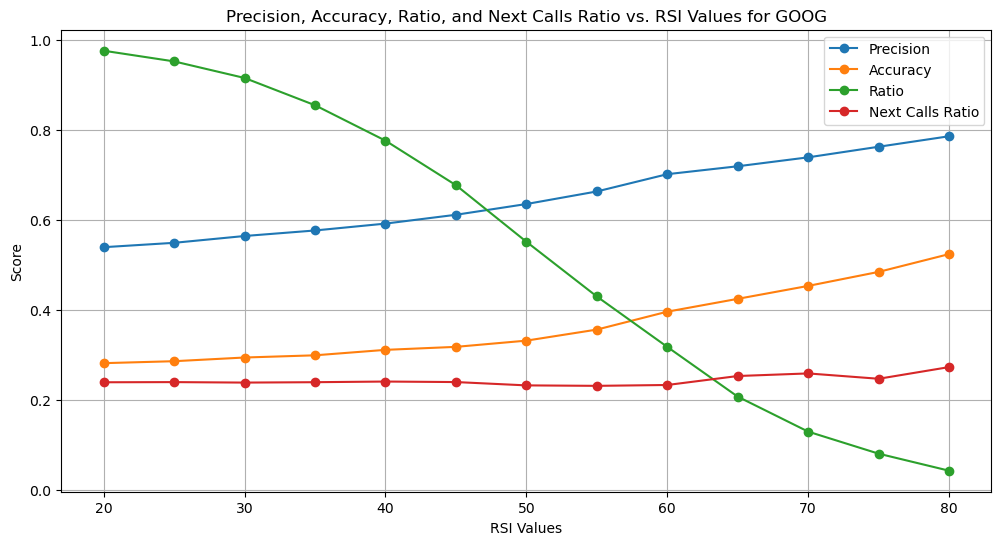

NVDA_aggregated_calls.csv NVDA_aggregated_puts.csv NVDA_rsi.csv
Input RSI: 20 | True Positives: 475 | False Positives: 430 | Total: 1902 | Length: 1981 | Total Ratio: 0.9601211509338717 | Next Calls Ratio: 115 | Average Change: 2.1873189473684205 | Average Neg Change: -2.1539065116279064
Input RSI: 25 | True Positives: 457 | False Positives: 401 | Total: 1817 | Length: 1981 | Total Ratio: 0.9172135285209491 | Next Calls Ratio: 113 | Average Change: 2.208099781181618 | Average Neg Change: -2.1339653366583535
Input RSI: 30 | True Positives: 443 | False Positives: 373 | Total: 1729 | Length: 1981 | Total Ratio: 0.872791519434629 | Next Calls Ratio: 108 | Average Change: 2.208933860045146 | Average Neg Change: -2.10846568364611
Input RSI: 35 | True Positives: 425 | False Positives: 338 | Total: 1606 | Length: 1981 | Total Ratio: 0.8107016658253408 | Next Calls Ratio: 107 | Average Change: 2.2131487058823516 | Average Neg Change: -2.050061834319523
Input RSI: 40 | True Positives: 389 | Fals

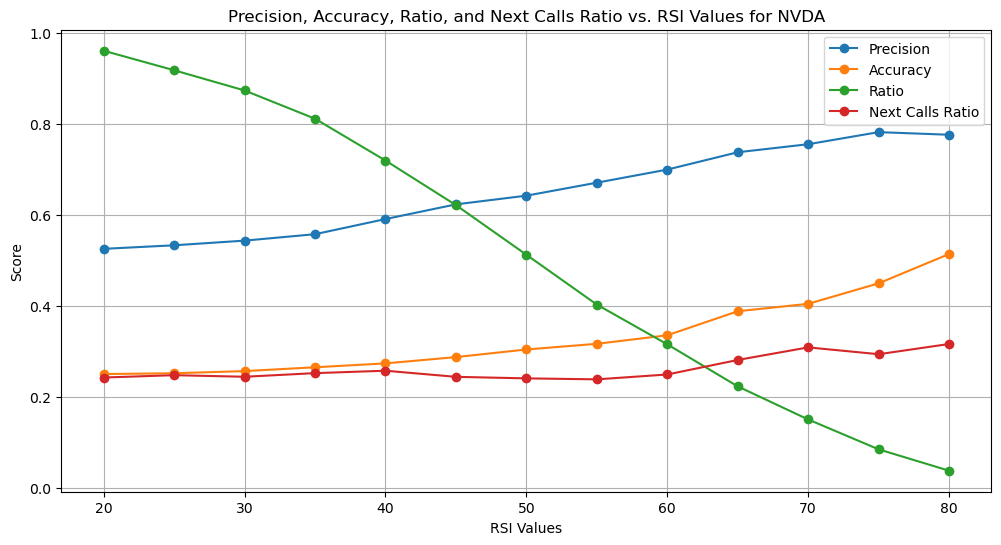

META_aggregated_calls.csv META_aggregated_puts.csv META_rsi.csv
Input RSI: 20 | True Positives: 514 | False Positives: 428 | Total: 1938 | Length: 1981 | Total Ratio: 0.9782937910146391 | Next Calls Ratio: 109 | Average Change: 1.3628071984435806 | Average Neg Change: -1.2439593457943932
Input RSI: 25 | True Positives: 506 | False Positives: 415 | Total: 1896 | Length: 1981 | Total Ratio: 0.9570923775870772 | Next Calls Ratio: 106 | Average Change: 1.365043083003953 | Average Neg Change: -1.2445421686746996
Input RSI: 30 | True Positives: 494 | False Positives: 381 | Total: 1818 | Length: 1981 | Total Ratio: 0.9177183240787481 | Next Calls Ratio: 101 | Average Change: 1.371773076923077 | Average Neg Change: -1.2530367454068259
Input RSI: 35 | True Positives: 479 | False Positives: 340 | Total: 1699 | Length: 1981 | Total Ratio: 0.8576476527006562 | Next Calls Ratio: 99 | Average Change: 1.385186221294364 | Average Neg Change: -1.2105700000000021
Input RSI: 40 | True Positives: 441 | Fa

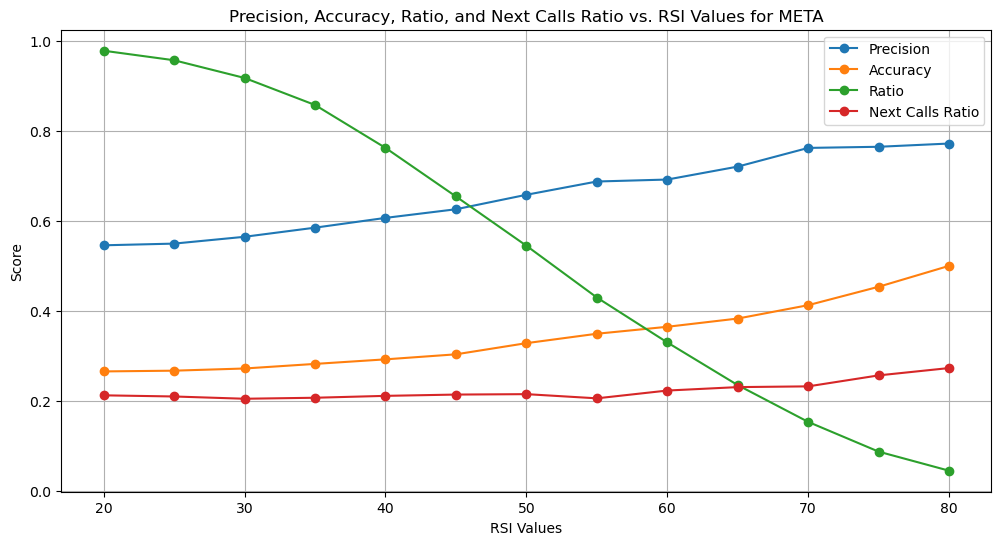

AAPL_aggregated_calls.csv AAPL_aggregated_puts.csv AAPL_rsi.csv
Input RSI: 20 | True Positives: 458 | False Positives: 446 | Total: 1935 | Length: 1981 | Total Ratio: 0.9767794043412418 | Next Calls Ratio: 90 | Average Change: 0.5205980349344969 | Average Neg Change: -0.4794928251121081
Input RSI: 25 | True Positives: 451 | False Positives: 417 | Total: 1880 | Length: 1981 | Total Ratio: 0.9490156486622918 | Next Calls Ratio: 88 | Average Change: 0.5204847006651875 | Average Neg Change: -0.4692983213429263
Input RSI: 30 | True Positives: 439 | False Positives: 391 | Total: 1798 | Length: 1981 | Total Ratio: 0.9076224129227662 | Next Calls Ratio: 86 | Average Change: 0.5234576309794977 | Average Neg Change: -0.4672826086956531
Input RSI: 35 | True Positives: 427 | False Positives: 346 | Total: 1670 | Length: 1981 | Total Ratio: 0.8430085815244825 | Next Calls Ratio: 84 | Average Change: 0.5258695550351276 | Average Neg Change: -0.46659913294797767
Input RSI: 40 | True Positives: 393 | F

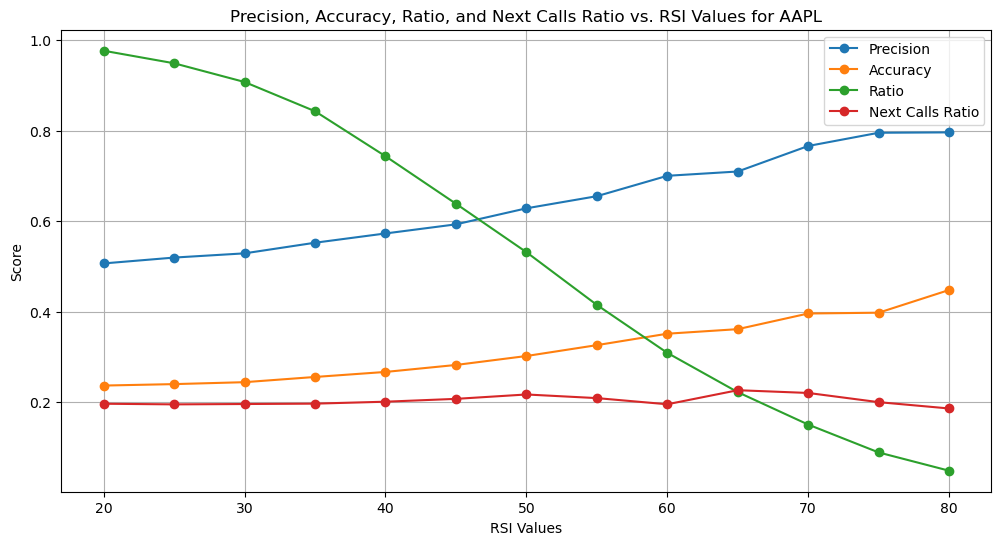

AMD_aggregated_calls.csv AMD_aggregated_puts.csv AMD_rsi.csv
Input RSI: 20 | True Positives: 513 | False Positives: 508 | Total: 1896 | Length: 1981 | Total Ratio: 0.9570923775870772 | Next Calls Ratio: 127 | Average Change: 0.7322830409356715 | Average Neg Change: -0.704486220472441
Input RSI: 25 | True Positives: 501 | False Positives: 471 | Total: 1805 | Length: 1981 | Total Ratio: 0.9111559818273599 | Next Calls Ratio: 124 | Average Change: 0.7324570858283426 | Average Neg Change: -0.6969787685774951
Input RSI: 30 | True Positives: 485 | False Positives: 408 | Total: 1664 | Length: 1981 | Total Ratio: 0.839979808177688 | Next Calls Ratio: 121 | Average Change: 0.7298527835051539 | Average Neg Change: -0.6819492647058828
Input RSI: 35 | True Positives: 455 | False Positives: 360 | Total: 1513 | Length: 1981 | Total Ratio: 0.7637556789500253 | Next Calls Ratio: 110 | Average Change: 0.7367993406593407 | Average Neg Change: -0.6861886111111106
Input RSI: 40 | True Positives: 419 | Fal

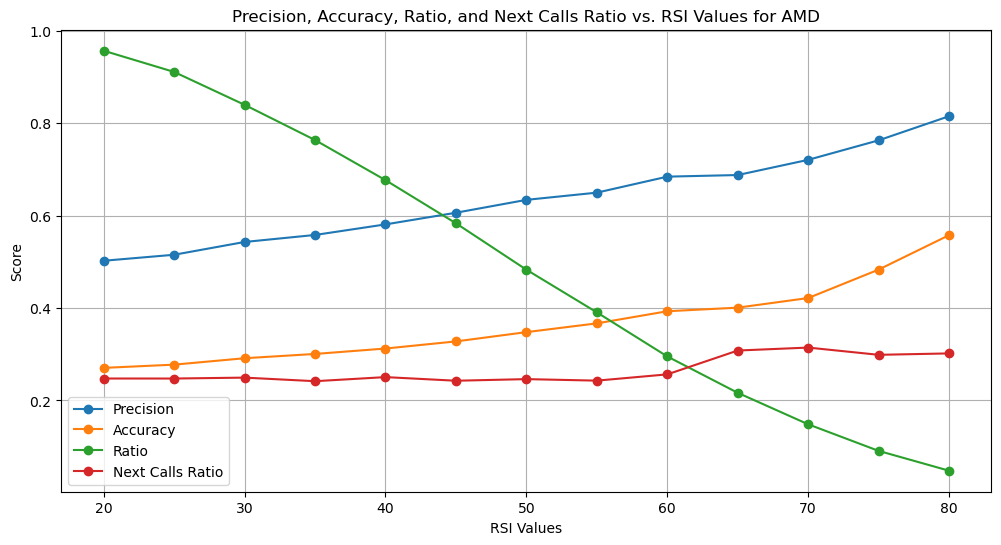

In [271]:
# List of stock tickers
stocks = ["AMZN", "MSFT", "TSLA", "GOOG", "NVDA", "META", "AAPL", "AMD"]

# Iterate over each stock ticker
for stock in stocks:
    # Define file names
    calls = f"{stock}_aggregated_calls.csv"
    puts = f"{stock}_aggregated_puts.csv"
    rsi = f"{stock}_rsi.csv"
    print(calls, puts, rsi)
    # Load data into dictionaries
    calls_dict = csv_to_dict(calls)
    puts_dict = csv_to_dict(puts)
    rsi_dict = rsi_csv_to_dict(rsi)

    # Plot metrics vs. RSI for the current stock
    plot_metrics_vs_rsi(rsi_dict, calls_dict, puts_dict, stock)

# Function to Test RSI Strategy on Puts and Plot

In [278]:
def calculate_precision_and_accuracy_puts(rsi_dict, calls_dict, puts_dict, input_rsi):
    true_positives, false_positives = 0, 0
    total, next_puts, length = 0, 0, len(rsi_dict)
    average_change, average_neg_change = 0, 0
    for timestamp, rsi in rsi_dict.items():
        rsi_value = rsi[0]
        timestamp_dt = datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        next_timestamp_dt = timestamp_dt + datetime.timedelta(minutes=5)
        next_timestamp_str = next_timestamp_dt.strftime('%Y-%m-%d %H:%M:%S')
        if float(rsi_value) <= input_rsi: 
            total += 1
        if timestamp in puts_dict and float(rsi_value) <= input_rsi:
            true_positives += 1
            if next_timestamp_str in puts_dict: 
                next_puts += 1
        if timestamp in calls_dict and float(rsi_value) <= input_rsi:
            false_positives += 1
            

    # Calculate precision, accuracy, and average change
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    accuracy = true_positives / total if total > 0 else  0
    
    # Print the metrics including the average change
    print("Input RSI:", input_rsi, "| True Positives:", true_positives, "| False Positives:", false_positives, "| Total:", total, "| Length:", length, "| Total Ratio:", total/length, "| Next Puts:", next_puts)
    
    # Return precision, accuracy, and ratio
    return precision, accuracy, total/length, next_puts/true_positives


In [281]:
import matplotlib.pyplot as plt

def plot_metrics_vs_rsi_puts(rsi_dict, calls_dict, puts_dict, ticker):
    """
    Plot precision, accuracy, ratio, and next_calls_ratio vs. RSI values.

    Args:
    - rsi_dict (dict): Dictionary containing RSI values.
    - calls_dict (dict): Dictionary containing call data.
    - puts_dict (dict): Dictionary containing put data.
    - ticker (str): Ticker symbol of the stock.
    """
    # Define the range of RSI values to try
    rsi_values = list(range(20, 81, 5))

    # Initialize lists to store precision, accuracy, ratio, and next_calls_ratio values
    precision_values = []
    accuracy_values = []
    ratio_values = []
    next_puts_ratio_values = []

    # Iterate over each RSI value
    for input_rsi in rsi_values:
        # Calculate precision, accuracy, ratio, and next_calls_ratio for the current RSI value
        precision, accuracy, ratio, next_puts_ratio = calculate_precision_and_accuracy_puts(rsi_dict, calls_dict, puts_dict, input_rsi)
        
        # Append precision, accuracy, ratio, and next_calls_ratio values to the lists
        precision_values.append(precision)
        accuracy_values.append(accuracy)
        ratio_values.append(ratio)
        next_puts_ratio_values.append(next_puts_ratio)

    # Plot precision, accuracy, ratio, and next_calls_ratio values
    plt.figure(figsize=(12, 6))

    # Plot precision
    plt.plot(rsi_values, precision_values, label='Precision', marker='o')

    # Plot accuracy
    plt.plot(rsi_values, accuracy_values, label='Accuracy', marker='o')

    # Plot ratio
    plt.plot(rsi_values, ratio_values, label='Ratio', marker='o')

    # Plot next_calls_ratio
    plt.plot(rsi_values, next_puts_ratio_values, label='Next Puts Ratio', marker='o')

    plt.title(f'Precision, Accuracy, Ratio, and Next Puts Ratio vs. RSI Values for {ticker}')
    plt.xlabel('RSI Values')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.show()

AMZN_aggregated_calls.csv AMZN_aggregated_puts.csv AMZN_rsi.csv
Input RSI: 20 | True Positives: 42 | False Positives: 9 | Total: 80 | Length: 1981 | Total Ratio: 0.04038364462392731 | Next Puts: 4
Input RSI: 25 | True Positives: 75 | False Positives: 19 | Total: 143 | Length: 1981 | Total Ratio: 0.07218576476527007 | Next Puts: 10
Input RSI: 30 | True Positives: 119 | False Positives: 43 | Total: 265 | Length: 1981 | Total Ratio: 0.1337708228167592 | Next Puts: 19
Input RSI: 35 | True Positives: 172 | False Positives: 61 | Total: 404 | Length: 1981 | Total Ratio: 0.2039374053508329 | Next Puts: 32
Input RSI: 40 | True Positives: 236 | False Positives: 101 | Total: 594 | Length: 1981 | Total Ratio: 0.29984856133266025 | Next Puts: 45
Input RSI: 45 | True Positives: 295 | False Positives: 126 | Total: 786 | Length: 1981 | Total Ratio: 0.3967693084300858 | Next Puts: 65
Input RSI: 50 | True Positives: 350 | False Positives: 174 | Total: 991 | Length: 1981 | Total Ratio: 0.5002523977788995

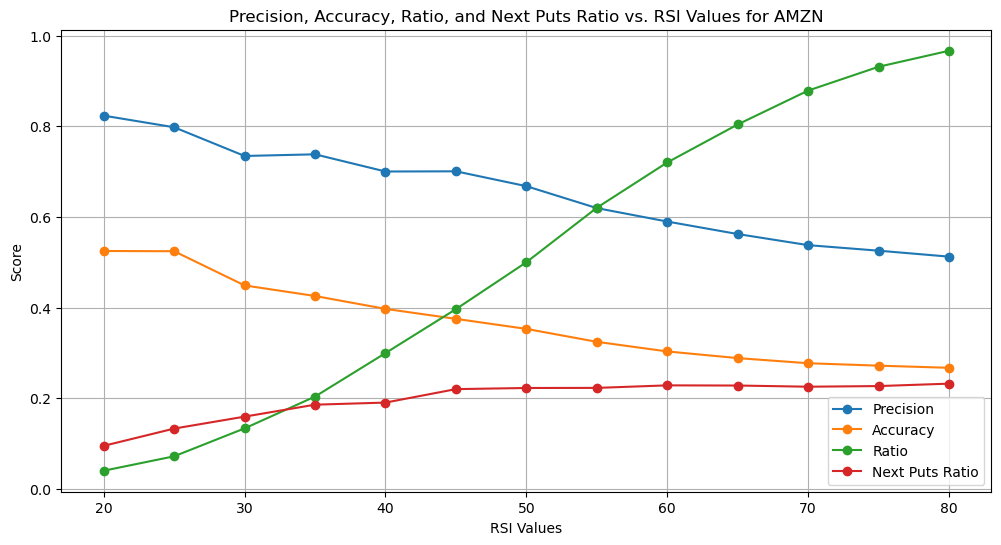

MSFT_aggregated_calls.csv MSFT_aggregated_puts.csv MSFT_rsi.csv
Input RSI: 20 | True Positives: 22 | False Positives: 9 | Total: 52 | Length: 1981 | Total Ratio: 0.02624936900555275 | Next Puts: 7
Input RSI: 25 | True Positives: 52 | False Positives: 14 | Total: 111 | Length: 1981 | Total Ratio: 0.05603230691569914 | Next Puts: 16
Input RSI: 30 | True Positives: 91 | False Positives: 26 | Total: 214 | Length: 1981 | Total Ratio: 0.10802624936900555 | Next Puts: 24
Input RSI: 35 | True Positives: 143 | False Positives: 54 | Total: 361 | Length: 1981 | Total Ratio: 0.18223119636547197 | Next Puts: 36
Input RSI: 40 | True Positives: 191 | False Positives: 82 | Total: 545 | Length: 1981 | Total Ratio: 0.2751135790005048 | Next Puts: 46
Input RSI: 45 | True Positives: 251 | False Positives: 133 | Total: 778 | Length: 1981 | Total Ratio: 0.3927309439676931 | Next Puts: 55
Input RSI: 50 | True Positives: 307 | False Positives: 175 | Total: 1000 | Length: 1981 | Total Ratio: 0.5047955577990914

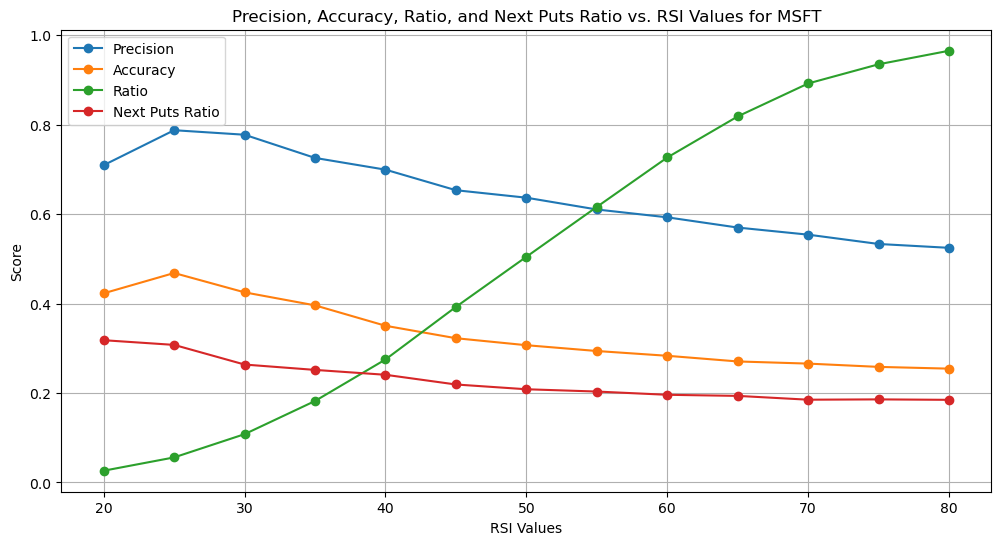

TSLA_aggregated_calls.csv TSLA_aggregated_puts.csv TSLA_rsi.csv
Input RSI: 20 | True Positives: 44 | False Positives: 15 | Total: 99 | Length: 1981 | Total Ratio: 0.049974760222110046 | Next Puts: 14
Input RSI: 25 | True Positives: 85 | False Positives: 27 | Total: 186 | Length: 1981 | Total Ratio: 0.09389197375063099 | Next Puts: 25
Input RSI: 30 | True Positives: 121 | False Positives: 45 | Total: 286 | Length: 1981 | Total Ratio: 0.14437152953054014 | Next Puts: 30
Input RSI: 35 | True Positives: 178 | False Positives: 63 | Total: 424 | Length: 1981 | Total Ratio: 0.21403331650681473 | Next Puts: 46
Input RSI: 40 | True Positives: 232 | False Positives: 105 | Total: 596 | Length: 1981 | Total Ratio: 0.3008581524482585 | Next Puts: 57
Input RSI: 45 | True Positives: 290 | False Positives: 148 | Total: 804 | Length: 1981 | Total Ratio: 0.40585562847046946 | Next Puts: 66
Input RSI: 50 | True Positives: 330 | False Positives: 194 | Total: 977 | Length: 1981 | Total Ratio: 0.49318525996

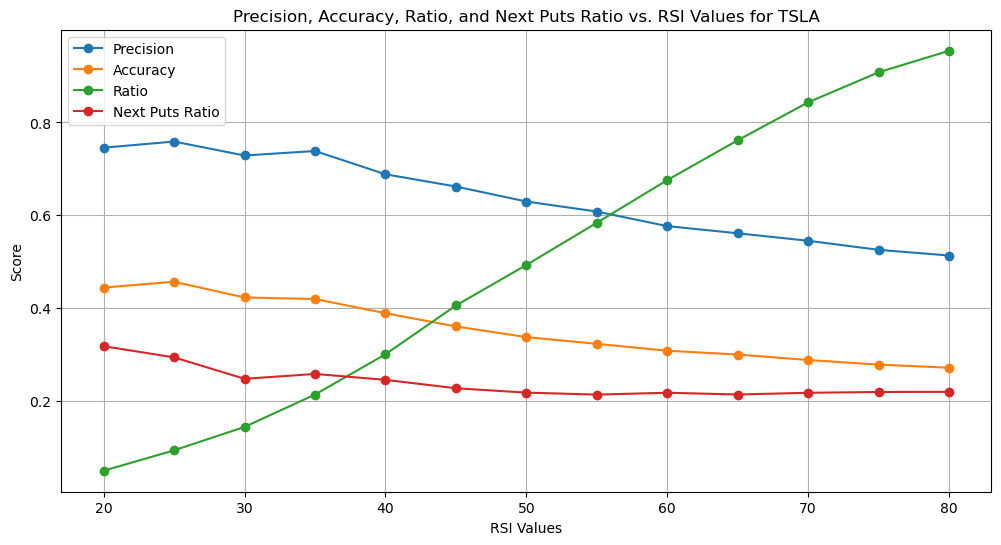

GOOG_aggregated_calls.csv GOOG_aggregated_puts.csv GOOG_rsi.csv
Input RSI: 20 | True Positives: 28 | False Positives: 3 | Total: 48 | Length: 1981 | Total Ratio: 0.024230186774356385 | Next Puts: 4
Input RSI: 25 | True Positives: 50 | False Positives: 8 | Total: 95 | Length: 1981 | Total Ratio: 0.04795557799091368 | Next Puts: 9
Input RSI: 30 | True Positives: 81 | False Positives: 14 | Total: 168 | Length: 1981 | Total Ratio: 0.08480565371024736 | Next Puts: 14
Input RSI: 35 | True Positives: 121 | False Positives: 41 | Total: 288 | Length: 1981 | Total Ratio: 0.1453811206461383 | Next Puts: 22
Input RSI: 40 | True Positives: 163 | False Positives: 69 | Total: 444 | Length: 1981 | Total Ratio: 0.22412922766279655 | Next Puts: 29
Input RSI: 45 | True Positives: 222 | False Positives: 121 | Total: 640 | Length: 1981 | Total Ratio: 0.32306915699141847 | Next Puts: 40
Input RSI: 50 | True Positives: 285 | False Positives: 185 | Total: 889 | Length: 1981 | Total Ratio: 0.44876325088339225 

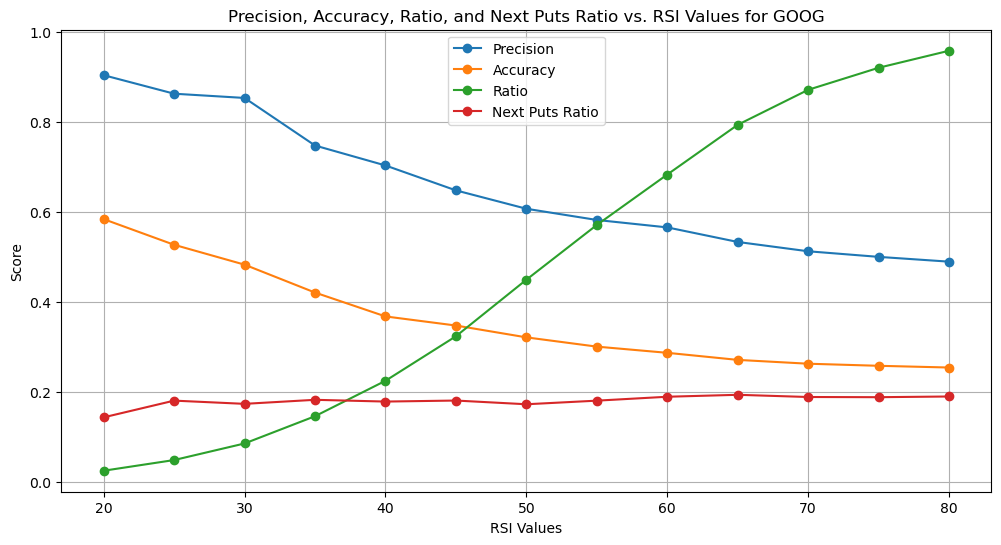

NVDA_aggregated_calls.csv NVDA_aggregated_puts.csv NVDA_rsi.csv
Input RSI: 20 | True Positives: 36 | False Positives: 11 | Total: 79 | Length: 1981 | Total Ratio: 0.039878849066128215 | Next Puts: 12
Input RSI: 25 | True Positives: 65 | False Positives: 29 | Total: 164 | Length: 1981 | Total Ratio: 0.08278647147905098 | Next Puts: 21
Input RSI: 30 | True Positives: 93 | False Positives: 43 | Total: 252 | Length: 1981 | Total Ratio: 0.127208480565371 | Next Puts: 25
Input RSI: 35 | True Positives: 128 | False Positives: 61 | Total: 375 | Length: 1981 | Total Ratio: 0.18929833417465927 | Next Puts: 39
Input RSI: 40 | True Positives: 196 | False Positives: 97 | Total: 557 | Length: 1981 | Total Ratio: 0.2811711256940939 | Next Puts: 55
Input RSI: 45 | True Positives: 252 | False Positives: 133 | Total: 751 | Length: 1981 | Total Ratio: 0.37910146390711763 | Next Puts: 66
Input RSI: 50 | True Positives: 294 | False Positives: 178 | Total: 967 | Length: 1981 | Total Ratio: 0.488137304391721

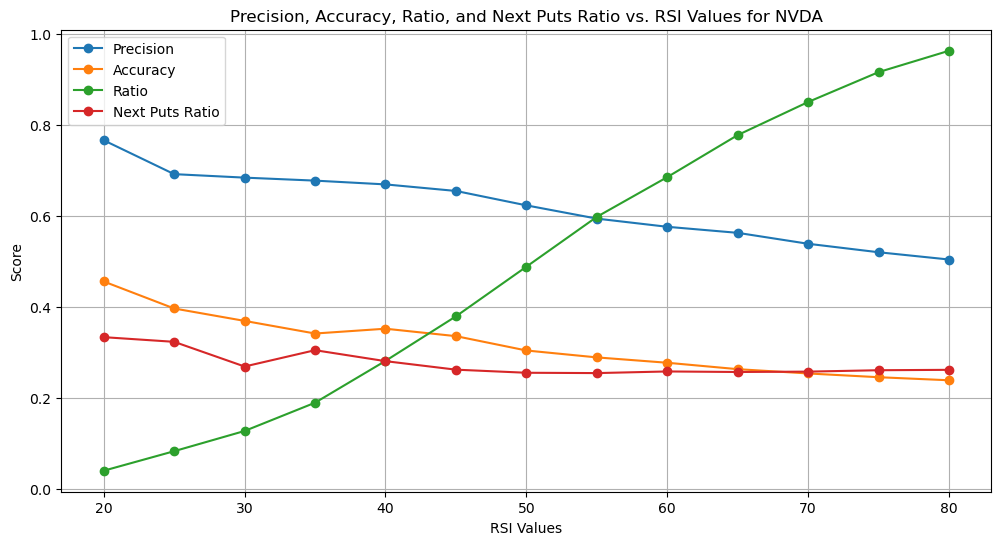

META_aggregated_calls.csv META_aggregated_puts.csv META_rsi.csv
Input RSI: 20 | True Positives: 25 | False Positives: 3 | Total: 43 | Length: 1981 | Total Ratio: 0.02170620898536093 | Next Puts: 5
Input RSI: 25 | True Positives: 38 | False Positives: 11 | Total: 85 | Length: 1981 | Total Ratio: 0.042907622412922765 | Next Puts: 10
Input RSI: 30 | True Positives: 72 | False Positives: 23 | Total: 163 | Length: 1981 | Total Ratio: 0.08228167592125189 | Next Puts: 17
Input RSI: 35 | True Positives: 113 | False Positives: 38 | Total: 282 | Length: 1981 | Total Ratio: 0.14235234729934376 | Next Puts: 32
Input RSI: 40 | True Positives: 167 | False Positives: 76 | Total: 471 | Length: 1981 | Total Ratio: 0.23775870772337204 | Next Puts: 38
Input RSI: 45 | True Positives: 218 | False Positives: 124 | Total: 685 | Length: 1981 | Total Ratio: 0.3457849570923776 | Next Puts: 45
Input RSI: 50 | True Positives: 269 | False Positives: 163 | Total: 902 | Length: 1981 | Total Ratio: 0.4553255931347804

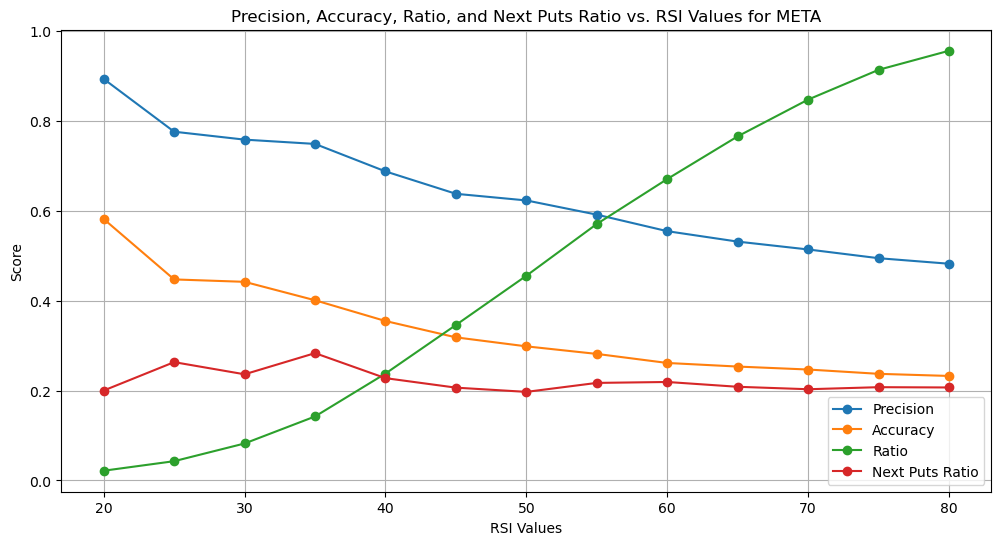

AAPL_aggregated_calls.csv AAPL_aggregated_puts.csv AAPL_rsi.csv
Input RSI: 20 | True Positives: 18 | False Positives: 10 | Total: 46 | Length: 1981 | Total Ratio: 0.023220595658758204 | Next Puts: 3
Input RSI: 25 | True Positives: 47 | False Positives: 17 | Total: 101 | Length: 1981 | Total Ratio: 0.05098435133770823 | Next Puts: 13
Input RSI: 30 | True Positives: 73 | False Positives: 29 | Total: 183 | Length: 1981 | Total Ratio: 0.09237758707723372 | Next Puts: 20
Input RSI: 35 | True Positives: 118 | False Positives: 41 | Total: 311 | Length: 1981 | Total Ratio: 0.15699141847551742 | Next Puts: 25
Input RSI: 40 | True Positives: 171 | False Positives: 75 | Total: 508 | Length: 1981 | Total Ratio: 0.25643614336193843 | Next Puts: 39
Input RSI: 45 | True Positives: 219 | False Positives: 111 | Total: 716 | Length: 1981 | Total Ratio: 0.3614336193841494 | Next Puts: 49
Input RSI: 50 | True Positives: 276 | False Positives: 150 | Total: 928 | Length: 1981 | Total Ratio: 0.46845027763755

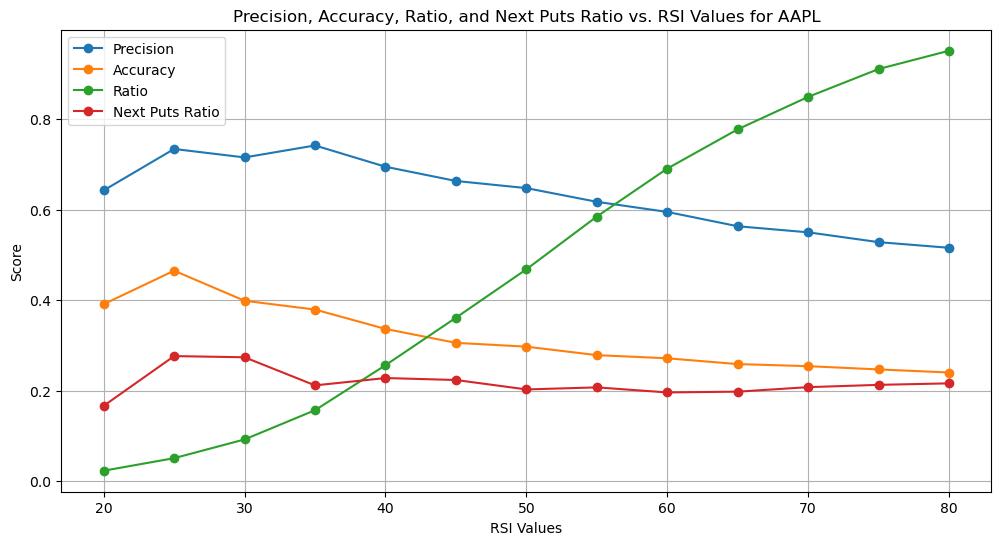

AMD_aggregated_calls.csv AMD_aggregated_puts.csv AMD_rsi.csv
Input RSI: 20 | True Positives: 41 | False Positives: 9 | Total: 85 | Length: 1981 | Total Ratio: 0.042907622412922765 | Next Puts: 6
Input RSI: 25 | True Positives: 78 | False Positives: 21 | Total: 176 | Length: 1981 | Total Ratio: 0.08884401817264008 | Next Puts: 17
Input RSI: 30 | True Positives: 141 | False Positives: 37 | Total: 317 | Length: 1981 | Total Ratio: 0.16002019182231197 | Next Puts: 36
Input RSI: 35 | True Positives: 189 | False Positives: 67 | Total: 468 | Length: 1981 | Total Ratio: 0.23624432104997475 | Next Puts: 45
Input RSI: 40 | True Positives: 247 | False Positives: 103 | Total: 640 | Length: 1981 | Total Ratio: 0.32306915699141847 | Next Puts: 62
Input RSI: 45 | True Positives: 303 | False Positives: 143 | Total: 825 | Length: 1981 | Total Ratio: 0.4164563351842504 | Next Puts: 74
Input RSI: 50 | True Positives: 357 | False Positives: 189 | Total: 1024 | Length: 1981 | Total Ratio: 0.516910651186269

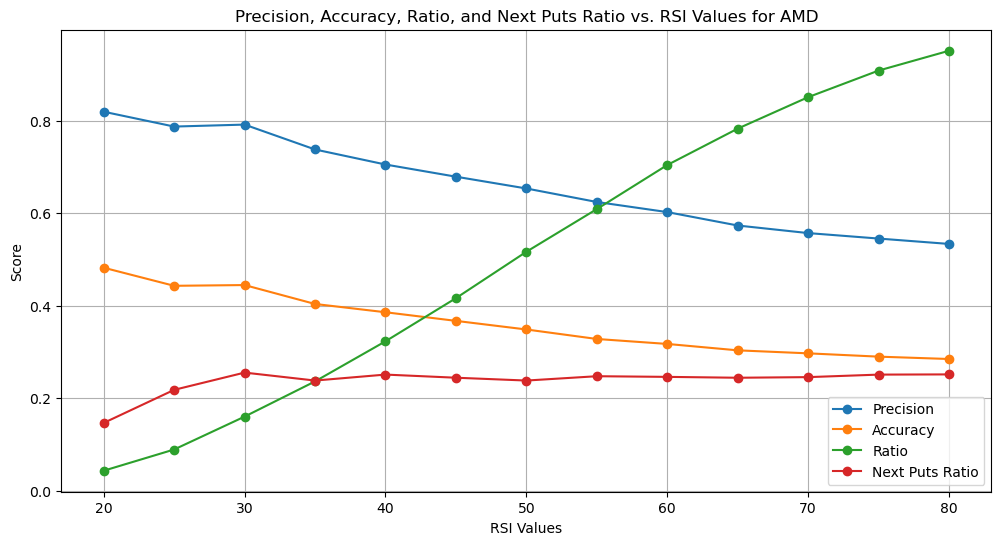

In [282]:
# List of stock tickers
stocks = ["AMZN", "MSFT", "TSLA", "GOOG", "NVDA", "META", "AAPL", "AMD"]

# Iterate over each stock ticker
for stock in stocks:
    # Define file names
    calls = f"{stock}_aggregated_calls.csv"
    puts = f"{stock}_aggregated_puts.csv"
    rsi = f"{stock}_rsi.csv"
    print(calls, puts, rsi)
    # Load data into dictionaries
    calls_dict = csv_to_dict(calls)
    puts_dict = csv_to_dict(puts)
    rsi_dict = rsi_csv_to_dict(rsi)

    # Plot metrics vs. RSI for the current stock
    plot_metrics_vs_rsi_puts(rsi_dict, calls_dict, puts_dict, stock)